In [73]:
import numpy as np
from numpy import fft,pi
import scipy.signal
import cPickle as pickle

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import ps_utils_new
import imp
imp.reload(ps_utils_new)
# from plot_styling import dark
import mwa_utils
imp.reload(mwa_utils)

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace
from scipy.linalg import sqrtm,inv

In [119]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

dat_dir = '/home/abrahamn/21cmIRxcor/zemcov14_data/'
ell_Cell_ciber = np.genfromtxt(dat_dir+'zemcov14_CIBER_data_with_errors_Cl.txt',skip_header=4,delimiter=',')
ell_Cell_eormodel = np.genfromtxt(dat_dir+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# CIBER's measurements are of \lambda*I_\lambda, which can be converted to I_f by dividing by f 
# see https://www.evernote.com/shard/s316/nl/2147483647/1d5cc7be-446f-4933-9450-629dd63020c4/
convert_to_kJy_per_sr = 1.e-9/(3.e8/1.1e-6)/(1.e3*1.e-26)
print(convert_to_kJy_per_sr)

ciber_ell = ell_Cell_ciber[1::3,0]
ciber_dell = ciber_ell[1:]-ciber_ell[:-1]
ciber_delta = ell_Cell_ciber[1::3,1]*convert_to_kJy_per_sr
ciber_ddelta_plus = np.abs(ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1])*convert_to_kJy_per_sr
ciber_ddelta_minus = np.abs(ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1])*convert_to_kJy_per_sr
ciber_ddelta = (ciber_ddelta_plus+ciber_ddelta_minus)/2.+1.e-3

eormodel_ell = ell_Cell_eormodel[:,1]*convert_to_kJy_per_sr
eormodel_delta = ell_Cell_eormodel[:,1]*convert_to_kJy_per_sr

0.366666666667


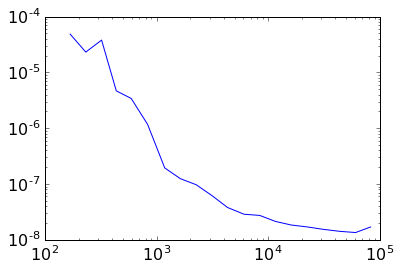

In [121]:
plt.loglog(ciber_ell,ciber_delta**2/ciber_ell**2)

In [2]:
matplotlib.rcParams.update({'font.size': 18})
plt.rc('font', family='Arial')
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False

In [3]:
label_groups = [ \
'02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I',\
'02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I',\
'02a57694o0301I 02a57694o0305I 02a57694o0309I 02a57694o0321I 02a57694o0325I 02a57694o0329I 02a57694o0341I 02a57694o0345I 02a57694o0349I',\
'02a57694o0300I 02a57694o0304I 02a57694o0308I 02a57694o0320I 02a57694o0324I 02a57694o0328I 02a57694o0340I 02a57694o0344I 02a57694o0348I',\
]
analysis_names = ['_'.join([l.split('o')[1] for l in label_group.split(' ')]) for label_group in label_groups]
print(analysis_names)

['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']


In [4]:
# xcor_data_dir = '/home/abrahamn/xcor_data/'
# analysis_root = xcor_data_dir+'analysis/ATLAS_mwa57694_rereduction/'
analysis_dir = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/'
num_frames = len(analysis_names)

ir_images = [pickle.load( open( analysis_dir+a+'_6amin.p', "rb" ) ) for a in analysis_names] # mask artifacts and sources

In [60]:
ir_images[0].keys()

['img_kjy_per_sr_crop',
 'lbins',
 'pspec',
 'params',
 'img_kjy_per_sr',
 'masked_img_zoom']

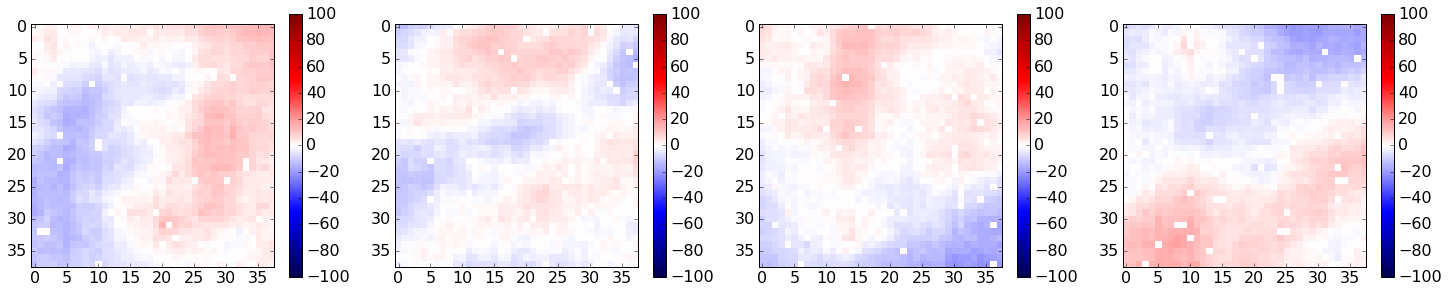

In [61]:
v1=-1.e2
v2=1.e2
cm = 'seismic'

plt.figure(figsize=(25,16))

for framei in range(num_frames):
    p = ir_images[framei]['params']
    img_crop_meansub = ir_images[framei]['img_kjy_per_sr'][p['x0']:p['x1'],p['y0']:p['y1']]
    img_crop_meansub[img_crop_meansub!=0] -= np.mean(img_crop_meansub[img_crop_meansub!=0])
    ir_images[framei]['img_kjy_per_sr_crop_meansub'] = img_crop_meansub
    
    plt.subplot(3,num_frames,framei+1)
    plt.imshow(img_crop_meansub,interpolation='nearest',cmap=cm,vmin=v1,vmax=v2)
    plt.colorbar()

In [8]:
# load MWA FHD cubes
fhdcubesroot = '/home/abrahamn/xcor_data/fhd_cubes/fhd_apb_EoR0_high_sem1_1/'

imp.reload(mwa_utils)
fhdlabel = 'Combined_obs_wedge_cut_plus_res_cut'
#fhdlabel = 'Combined_obs_golden'
freq_averaged_cubedat0,freq_averaged_cubedat1 = mwa_utils.load_freq_averaged_odd_even_cubedat(fhdcubesroot,fhdlabel)

In [35]:
mwa_image_full = mwa_utils.MWAImage(freq_averaged_cubedat0,freq_averaged_cubedat1, p['actual_coarse_res_amin'], int(10.*60/p['actual_coarse_res_amin']))

initializing MWAImage object
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
psf is centered at (x,y) = (49,49)
applying uniform weighting
applying uniform weighting
applying uniform weighting
applying uniform weighting


In [54]:
# load and uniformly weight MWA images

imp.reload(mwa_utils)
mwa_images = []
for framei in range(4):
    p = ir_images[framei]['params']
    
    mwa_images.append(mwa_utils.MWAImage(freq_averaged_cubedat0,freq_averaged_cubedat1, p['actual_coarse_res_amin'], ir_images[0]['img_kjy_per_sr'].shape[0],\
                                 crop_before_uniform_weighting_params=(p['n_frame'],p['x0']+p['n_frame']/2,p['y0']+p['n_frame']/2)))

initializing MWAImage object
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
psf is centered at (x,y) = (59,59)
cropping before applying uniform weighting
cropping around (36,82)
cropping around (36,82)
cropping around (36,82)
cropping around (36,82)
cropping around (59,59)
cropping around (59,59)
applying uniform weighting
applying uniform weighting
applying uniform weighting
applying uniform weighting
initializing MWAImage object
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
psf is centered at (x,y) = (59,59)
cropping before applying uniform weighting
cropping around (85,83)
cropping around (85,83)
cropping around (85,83)
cropping around (85,83)
cropping around (59,59)
cropping around (59,59)
applying uniform weighting
applying uniform weighting
applying uniform weighting
applying uniform weighting
initializi

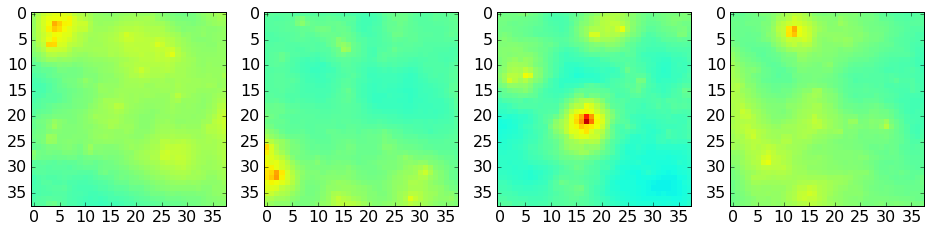

In [55]:
v1,v2 = -1.e8,1.e8
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0,interpolation='nearest',vmin=v1,vmax=v2)

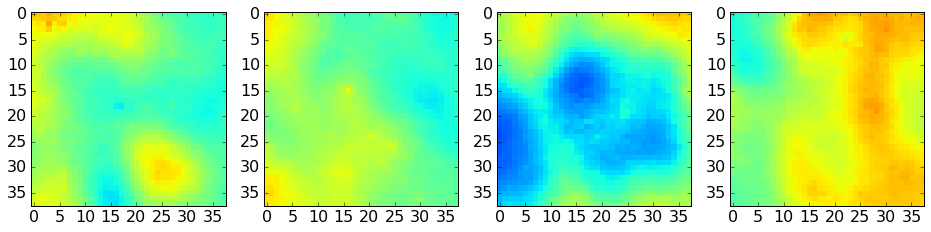

In [56]:
v1,v2 = -1.e7,1.e7
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0-mwa_images[i].model_xx0,interpolation='nearest',vmin=v1,vmax=v2)

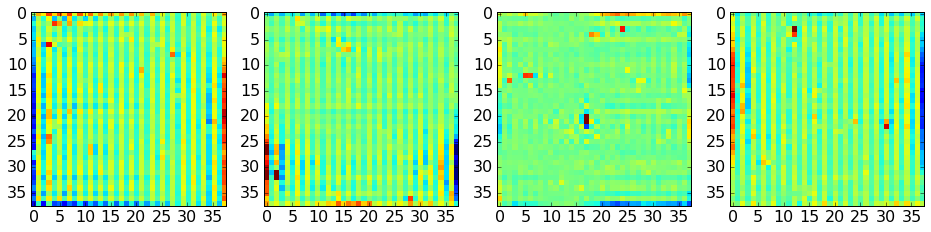

In [57]:
v1,v2 = -500,500
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx_u0,interpolation='nearest',vmin=v1,vmax=v2)

lmag.max() = 2514
lmag.max() = 2514
lmag.max() = 2514
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539


(200, 2600)

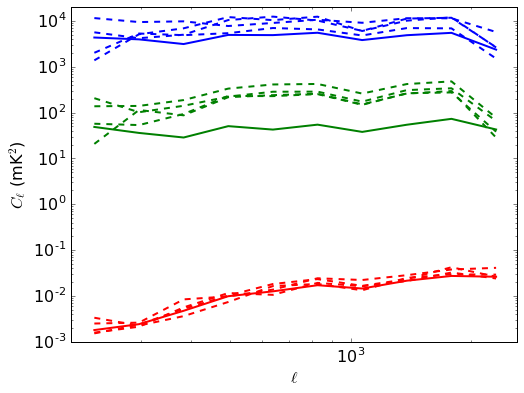

In [58]:
plt.figure(figsize=(8,6))

nbins = 10
lmin,lmax = 200,2600

use_hann = False
use_backsub=True
uselogbins=True
imp.reload(mwa_utils)
lbincenters, Cl_dirty0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0, mwa_image_full.weights_xx0, mwa_image_full.dtheta_rad, \
                                                                   nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
lbincenters, Cl_res0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.model_xx_u0, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, \
                                                                 nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
lbincenters, Cl_dirty_diff, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.dirty_xx_u1, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, \
                                                                       nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)

plt.loglog(lbincenters,Cl_dirty0*1.e6,'b-',linewidth=2) # the 1.e6 converts from K to mK
plt.loglog(lbincenters,Cl_res0*1.e6,'g-',linewidth=2)
plt.loglog(lbincenters,Cl_dirty_diff*1.e6,'r-',linewidth=2)

for i in range(num_frames):
    lbincenters_frame, Cl_dirty0_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0, mwa_images[i].weights_xx0, mwa_images[i].dtheta_rad,\
                                                                                               nbins,lmin,lmax,hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
    lbincenters_frame, Cl_res0_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].model_xx_u0, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad,\
                                                                                             nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
    lbincenters_frame, Cl_dirty_diff_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].dirty_xx_u1, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad,\
                                                                                             nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)

    plt.loglog(lbincenters_frame,Cl_dirty0_frame*1.e6,'b--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_res0_frame*1.e6,'g--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_dirty_diff_frame*1.e6,'r--',linewidth=2)

matplotlib.rcParams.update({'font.size': 16})
plt.ylabel(r'$C_\ell$ (mK$^2$)')
plt.xlabel(r'$\ell$')
plt.ylim([1.e-3,2.e4])
plt.xlim([200,2600])

In [223]:
def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def calc_mwa_ir_cross_spectrum(mwa_img_u,mwa_weights_img,ir_img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,filt_small_lx_and_ly_bins=False):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)
    n = mwa_img_u.shape[0]
    
    lvals = np.fft.fftfreq(n)*2*pi/dtheta_rad
    dl = np.abs(lvals[1]-lvals[0])
    lx,ly = np.meshgrid(lvals,lvals)
    lmag  = np.sqrt(lx**2+ly**2)
    ft_mask = (np.abs(lx)>2*dl)&(np.abs(ly)>2*dl)
    print('lmax = %d'%np.max(lmag))
        
    # FFT the (MWA dirty image) and (IR image)
    ir_ft = np.fft.fft2(ir_img-ir_img.mean())
    mwa_dirty_ft = np.fft.fft2(mwa_img_u-mwa_img_u.mean())
    mwa_weights_ft = np.abs(np.fft.fft2(mwa_weights_img-mwa_weights_img.mean()))
    
    xspec_binned = np.zeros(nbins)
    mwaspec_binned = np.zeros(nbins)
    irspec_binned = np.zeros(nbins)
    
    bin_counts = np.zeros(nbins)
    bin_sum_weights = np.zeros(nbins)
    bin_sum_squared_weights = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= ft_mask
        bin_counts[bini] = np.sum(inbin)

        xspec_binned[bini] = np.sum(ir_ft[inbin]*np.conj(mwa_dirty_ft[inbin])*mwa_weights_ft[inbin])/np.sum(mwa_weights_ft[inbin])
        mwaspec_binned[bini] = np.sum(np.abs(mwa_dirty_ft[inbin])**2*mwa_weights_ft[inbin]**2)/np.sum(mwa_weights_ft[inbin]**2)
        irspec_binned[bini] = np.mean(np.abs(ir_ft[inbin])**2)
        
        bin_sum_weights[bini] = np.sum(mwa_weights_ft[inbin])
        bin_sum_squared_weights[bini] = np.sum(mwa_weights_ft[inbin]**2)
        
    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,mwaspec_binned*pspec_norm,irspec_binned*pspec_norm,xspec_binned*pspec_norm,bin_counts,bin_sum_weights,bin_sum_squared_weights

def vec2arr(v):
    return np.array(v).flatten()

def calc_mwa_ir_cross_spectrum_oqe(mwa_img_u,mwa_weights_img,ir_img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,filt_small_lx_and_ly_bins=False,verbose=False):
    n = ir_img.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(ir_img.flatten()).T
    x21 = matrix(mwa_img_u.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            if filt_small_lx_and_ly_bins:
                ft_filt = (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])&ft_filt),lbincenters[bini]))
            else:
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
        return Ccommabini

    print('a '),
    # generate the fourier transform matrix to transform covariances
    lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
    lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
    F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2
    
    # generate C21inv
    print('generating C21')
    C21 = F*np.matrix(np.diag(mwa_weights_img.flatten()))*conj(F).T
    print('inverting C21')
    C21inv = inv(C21)
    
    # generate Cirinv
    print('generating Cir')
    pirguess = np.interp(lbincenters,ciber_ell,ciber_delta**2/ciber_ell**2)
    Cirguess_ft = matrix(np.diag( 10.**np.interp(np.log10(lmaggrid.flatten()),np.log10(lbincenters),np.log10(pirguess/norm/n**2)) ))   
    Cirsignal = F*Cirguess_ft*conj(F).T
    print('c '),
    Cirmask = 1.e5*np.matrix(np.diag(ir_img.flatten()==0))
    print('invirting Cir ')
    Cirinv = inv(Cirsignal + Cirmask)

    print('e '),
    # calculate q_alpha
    q = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cirinv_mats = []
    Ccomma_times_C21inv_mats = []
    print('\nbins: '),
    for bini in range(nbins):
        print(bini),
        Ccommabini = gen_Ccommabini(bini)
        Ccomma_times_Cirinv_mats.append(Ccommabini*Cirinv)
        Ccomma_times_C21inv_mats.append(Ccommabini*C21inv)
        
        q[bini] = .5*real(x21.T*C21inv*Ccomma_times_Cirinv_mats[bini]*xir).item()

    # calculate Fisher matrix
    Fish = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish[i,j] = np.real(.5*trace(Ccomma_times_C21inv_mats[i]*Ccomma_times_Cirinv_mats[j]))
            Fish[j,i] = Fish[i,j]
    
    p0 = vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrtm(Fish),axis=0))
    p1 = vec2arr(inv(Fish)*q*norm)

    return lbincenters,p1,Fish

lmax = 2539

dl = 94
12 cells in \ell=419.4 bin
40 cells in \ell=585.9 bin
96 cells in \ell=818.4 bin
216 cells in \ell=1143.2 bin
468 cells in \ell=1596.9 bin
257 cells in \ell=2230.7 bin
a 

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


 generating C21
inverting C21
generating Cir


/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:101: RuntimeWarning: divide by zero encountered in log10


c  invirting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 lmax = 2539

dl = 94
a  generating C21
inverting C21
generating Cir
c  invirting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 lmax = 2539

dl = 94
a  generating C21
inverting C21
generating Cir
c  invirting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 lmax = 2539

dl = 94
a  generating C21
inverting C21
generating Cir
c  invirting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5


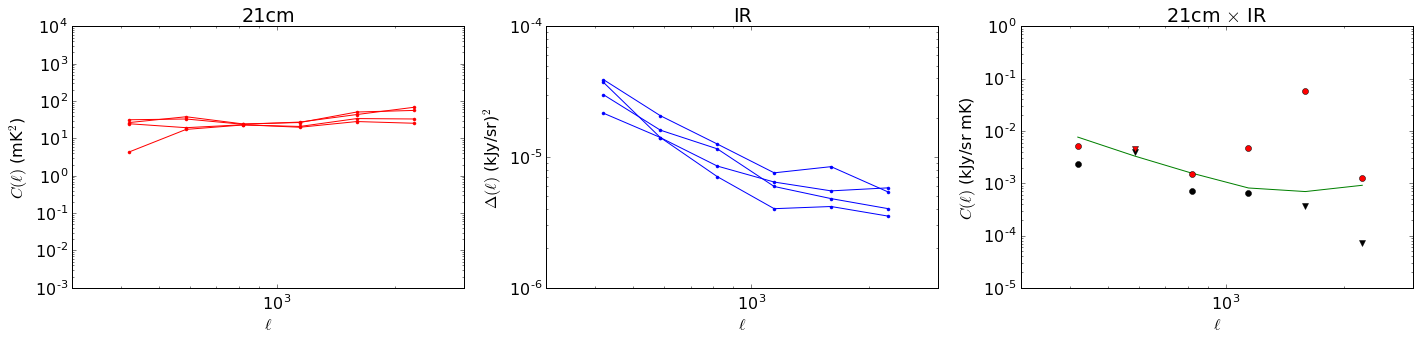

In [246]:
lmin,lmax = 350,2600

irspecs_fft = []
mwaspecs_fft = []
xspecs_fft = []
xspecs_oqe = []
for framei in range(num_frames):
    lbins,mwaspec,irspec,xspec,bin_counts,bin_sum_weights,bin_sum_sq_weights = calc_mwa_ir_cross_spectrum(mwa_images[framei].dirty_xx_u0 - mwa_images[framei].model_xx_u0,\
                                                                                                          mwa_images[framei].weights_xx0,\
                                                                                                          ir_images[framei]['img_kjy_per_sr_crop_meansub'],\
                                                                                                          dtheta_rad=ir_images[0]['params']['actual_coarse_res_amin']/60*np.pi/180.,\
                                                                                                          nbins=6,lmin=lmin,lmax=lmax,
                                                                                                         filt_small_lx_and_ly_bins=True)
    irspecs_fft.append(irspec)
    mwaspecs_fft.append(mwaspec)
    xspecs_fft.append(xspec)
    
    lbins,p0,Fish = calc_mwa_ir_cross_spectrum_oqe(mwa_images[framei].dirty_xx_u0 - mwa_images[framei].model_xx_u0,\
                                                                                                          mwa_images[framei].weights_xx0,\
                                                                                                          ir_images[framei]['img_kjy_per_sr_crop_meansub'],\
                                                                                                          dtheta_rad=ir_images[0]['params']['actual_coarse_res_amin']/60*np.pi/180.,\
                                                                                                          nbins=6,lmin=lmin,lmax=lmax,\
                                                                                                         filt_small_lx_and_ly_bins=True,verbose=(framei==0))
    xspecs_oqe.append(p0)


irspecs,mwaspecs,xspecs = np.array(irspecs),np.array(mwaspecs),np.array(xspecs)
irspecs_mean = np.mean(irspecs,axis=0)
mwaspecs_mean = np.mean(mwaspecs,axis=0)
xspecs_mean = np.mean(xspecs,axis=0)


plt.figure(figsize=(20,5))
matplotlib.rcParams.update({'font.size': 16})

x1,x2 = 300,3000

plt.subplot(131)
for i in range(4): plt.loglog(lbins,mwaspecs[i]*1.e6,'r.-')
#plt.loglog(lbins,mwaspecs_mean*1.e6,'r-',linewidth=2)
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (mK$^2$)')
plt.title('21cm')
plt.xlim([x1,x2])
plt.ylim([1.e-3,1.e4])

plt.subplot(132)
for i in range(4): plt.loglog(lbins,irspecs[i],'b.-')
#plt.loglog(lbins,irspecs_mean,'b-',linewidth=2)
plt.xlabel('$\ell$')
plt.ylabel('$\Delta(\ell)$ (kJy/sr)$^2$')
plt.title('IR')
plt.xlim([x1,x2])
#plt.ylim([.01,200])
#plt.ylim([1.e-6,1.e-2])

plt.subplot(133)
ispos = xspecs_mean>0
isneg = xspecs_mean<0
plt.loglog(lbins[ispos],xspecs_mean[ispos]*1.e3,'ko')
plt.loglog(lbins[isneg],-xspecs_mean[isneg]*1.e3,'kv')
plt.loglog(lbins,np.sqrt(irspecs_mean*mwaspecs_mean)/np.sqrt(bin_counts)*1.e3,'g-')

xspec_oqe_mean = np.mean(np.array(xspecs_oqe),axis=0)
ispos = xspec_oqe_mean>0
isneg = xspec_oqe_mean<0
plt.loglog(lbins[ispos],xspec_oqe_mean[ispos]*1.e3,'ro')
plt.loglog(lbins[isneg],-xspec_oqe_mean[isneg]*1.e3,'rv')

plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr mK)')
plt.title(r'21cm $\times$ IR')
plt.xlim([x1,x2])
plt.ylim([1.e-5,1])

plt.tight_layout()

#plt.savefig('radio_and_ir_xspec_allhann.pdf',bbox_inches='tight')

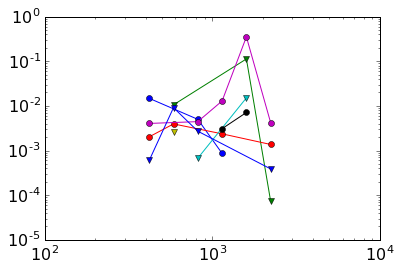

In [232]:
for i in range(4):
    ispos = xspecs_oqe[i]>0
    isneg = xspecs_oqe[i]<0
    plt.loglog(lbins[ispos],xspecs_oqe[i][ispos]*1.e3,'o-')
    plt.loglog(lbins[isneg],-xspecs_oqe[i][isneg]*1.e3,'v-')

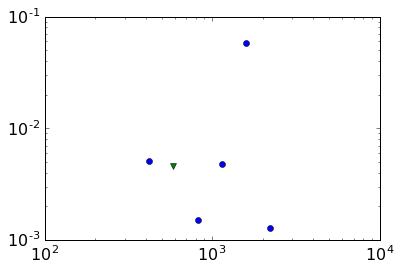